In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score
from glob import glob

In [2]:
class SaliencyDatasetLateFusion(Dataset):
    def __init__(self, rgb_paths, ir_paths, mask_paths, transform_image=None, transform_mask=None):
        self.rgb_paths = rgb_paths
        self.ir_paths = ir_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb_image = Image.open(self.rgb_paths[idx]).convert("RGB")
        ir_image = Image.open(self.ir_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform_image:
            rgb_image = self.transform_image(rgb_image)
            ir_image = self.transform_image(ir_image)

        if self.transform_mask:
            mask = self.transform_mask(mask)

        return rgb_image, ir_image, mask

In [3]:
rgb_dirs = [
    r"/home/samy/shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/images/RGB"
]

ir_dirs = [
    r"/home/samy/shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/images/IR_norm8bit"
]

mask_dirs = [
    r"/home/samy/shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/Saliency_map/RGB"
]

# Helper to gather and sort all paths
def collect_image_paths(dirs):
    paths = []
    for d in dirs:
        paths.extend(glob(os.path.join(d, "*.png")))
        paths.extend(glob(os.path.join(d, "*.jpg")))
        paths.extend(glob(os.path.join(d, "*.jpeg")))
    return sorted(paths)

rgb_paths = collect_image_paths(rgb_dirs)
ir_paths = collect_image_paths(ir_dirs)
mask_paths = collect_image_paths(mask_dirs)

assert len(rgb_paths) == len(ir_paths) == len(mask_paths), "Mismatch in dataset lengths"


In [4]:
train_rgb, test_rgb, train_ir, test_ir, train_masks, test_masks = train_test_split(
    rgb_paths, ir_paths, mask_paths, test_size=0.2, random_state=42
)

transform_image = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])

train_dataset = SaliencyDatasetLateFusion(train_rgb, train_ir, train_masks, transform_image, transform_mask)
test_dataset = SaliencyDatasetLateFusion(test_rgb, test_ir, test_masks, transform_image, transform_mask)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [5]:
class Saliency_LateFusion(nn.Module):
    def __init__(self):
        super(Saliency_LateFusion, self).__init__()

        # RGB Encoder
        self.rgb_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # IR Encoder
        self.ir_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # Fusion + Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1), nn.Sigmoid()
        )

    def forward(self, rgb, ir):
        rgb_feat = self.rgb_encoder(rgb)
        ir_feat = self.ir_encoder(ir)
        fused = torch.cat([rgb_feat, ir_feat], dim=1)
        out = self.decoder(fused)
        return out


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_LateFusion().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for rgb, ir, masks in train_loader:
        rgb, ir, masks = rgb.to(device), ir.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(rgb, ir)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/100], Loss: 0.3230
Epoch [2/100], Loss: 0.2087
Epoch [3/100], Loss: 0.2050
Epoch [4/100], Loss: 0.1950
Epoch [5/100], Loss: 0.1864
Epoch [6/100], Loss: 0.1839
Epoch [7/100], Loss: 0.1806
Epoch [8/100], Loss: 0.1787
Epoch [9/100], Loss: 0.1802
Epoch [10/100], Loss: 0.1758
Epoch [11/100], Loss: 0.1729
Epoch [12/100], Loss: 0.1710
Epoch [13/100], Loss: 0.1703
Epoch [14/100], Loss: 0.1691
Epoch [15/100], Loss: 0.1655
Epoch [16/100], Loss: 0.1614
Epoch [17/100], Loss: 0.1611
Epoch [18/100], Loss: 0.1590
Epoch [19/100], Loss: 0.1586
Epoch [20/100], Loss: 0.1580
Epoch [21/100], Loss: 0.1584
Epoch [22/100], Loss: 0.1536
Epoch [23/100], Loss: 0.1570
Epoch [24/100], Loss: 0.1549
Epoch [25/100], Loss: 0.1533
Epoch [26/100], Loss: 0.1513
Epoch [27/100], Loss: 0.1526
Epoch [28/100], Loss: 0.1505
Epoch [29/100], Loss: 0.1520
Epoch [30/100], Loss: 0.1472
Epoch [31/100], Loss: 0.1479
Epoch [32/100], Loss: 0.1463
Epoch [33/100], Loss: 0.1472
Epoch [34/100], Loss: 0.1466
Epoch [35/100], Loss: 0

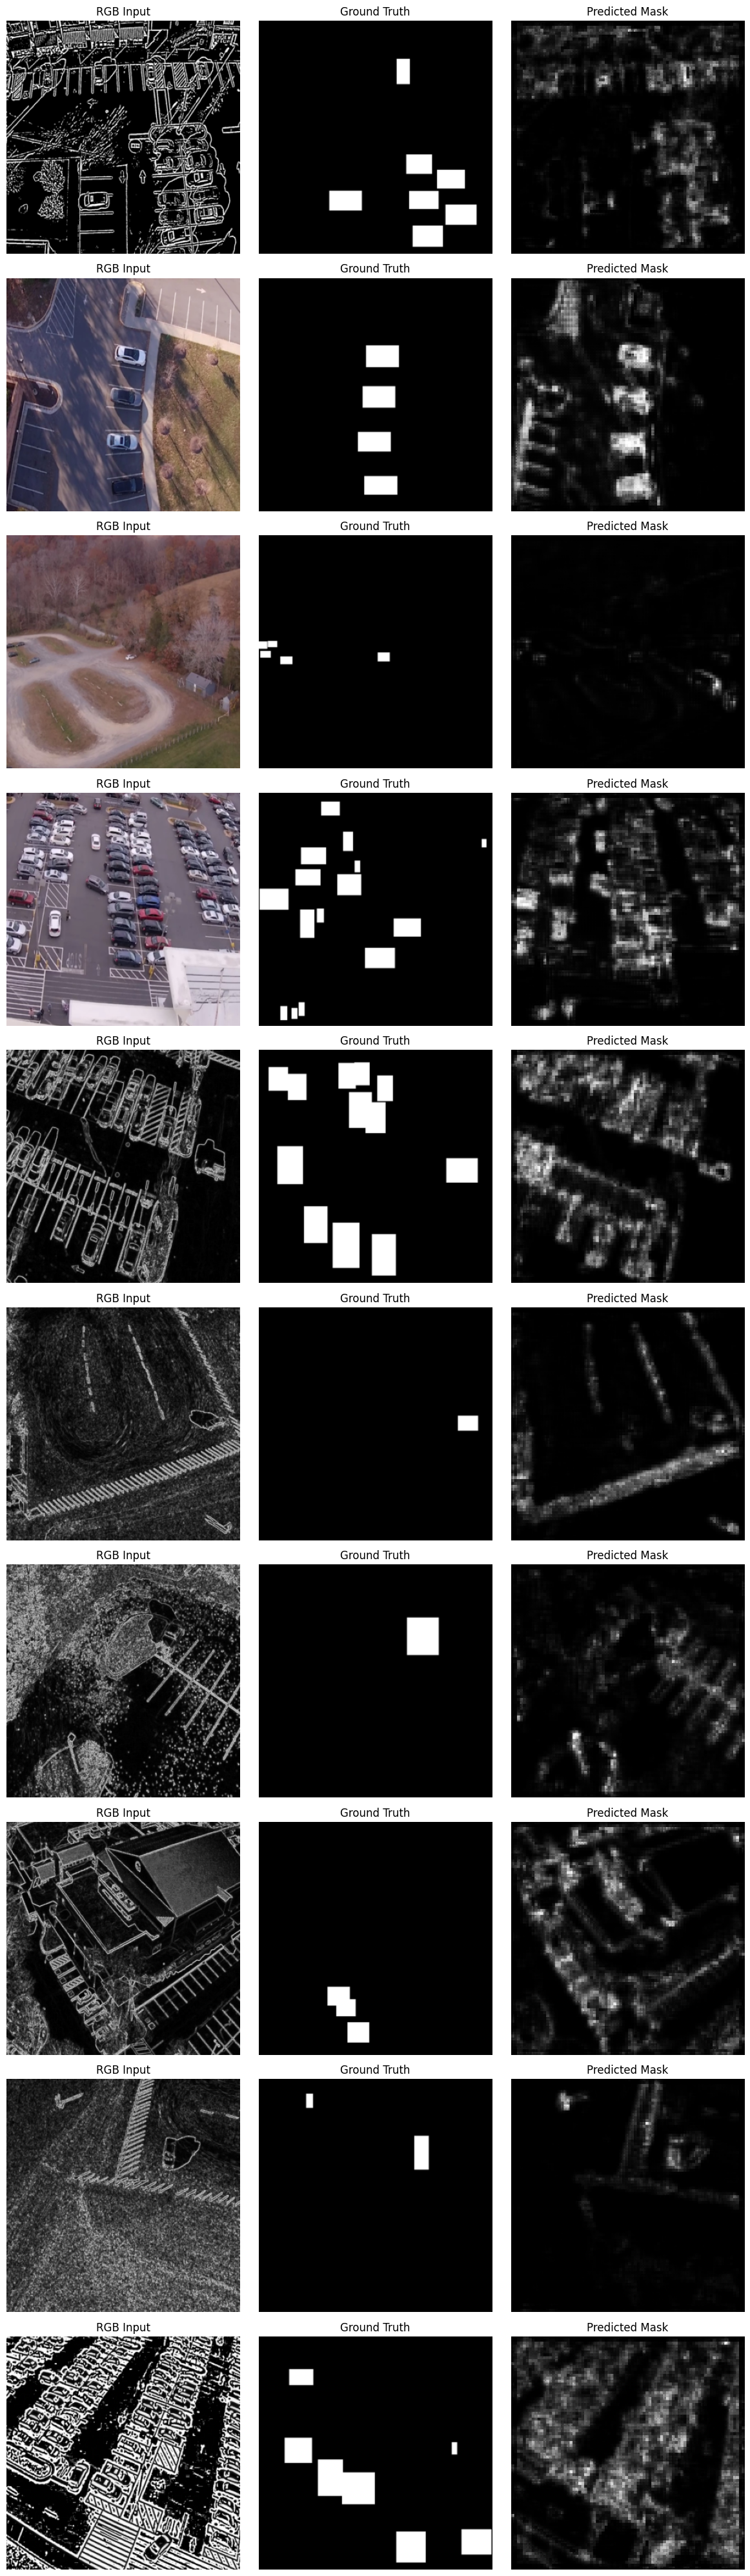

In [8]:
model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(10, 3, figsize=(12, 40))
    for idx in range(10):
        rgb, ir, mask = test_dataset[idx]
        rgb = rgb.unsqueeze(0).to(device)
        ir = ir.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        output = model(rgb, ir)

        rgb_np = rgb[0].permute(1, 2, 0).cpu().numpy()
        mask_np = mask[0][0].cpu().numpy()
        output_np = output[0][0].cpu().numpy()

        axes[idx, 0].imshow(rgb_np)
        axes[idx, 0].set_title("RGB Input")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(mask_np, cmap='gray')
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis("off")

        axes[idx, 2].imshow(output_np, cmap='gray')
        axes[idx, 2].set_title("Predicted Mask")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [9]:
torch.save(model.state_dict(), "/home/samy/shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion_d2.pth")
print("Model saved as saliency_model_late_fusion_d2.pth")

Model saved as saliency_model_late_fusion_d2.pth


In [10]:
# Instantiate model and load weights
model = Saliency_LateFusion().to(device)
model.load_state_dict(torch.load("/home/samy/shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion_d2.pth"))
model.eval()

Saliency_LateFusion(
  (rgb_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ir_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv

In [11]:
# ---------------------- Model Summary ---------------------
summary(model, input_size=[(3, 320, 320), (1, 320, 320)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 320]             896
              ReLU-2         [-1, 32, 320, 320]               0
         MaxPool2d-3         [-1, 32, 160, 160]               0
            Conv2d-4         [-1, 64, 160, 160]          18,496
              ReLU-5         [-1, 64, 160, 160]               0
         MaxPool2d-6           [-1, 64, 80, 80]               0
            Conv2d-7         [-1, 32, 320, 320]             320
              ReLU-8         [-1, 32, 320, 320]               0
         MaxPool2d-9         [-1, 32, 160, 160]               0
           Conv2d-10         [-1, 64, 160, 160]          18,496
             ReLU-11         [-1, 64, 160, 160]               0
        MaxPool2d-12           [-1, 64, 80, 80]               0
           Conv2d-13          [-1, 128, 80, 80]         147,584
             ReLU-14          [-1, 128,

In [12]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    min_frac = float('inf')
    for _, masks in dataloader:
        m_np = masks.numpy()  # shape (B,1,H,W)
        for m in m_np:
            binary = (m[0] >= bin_thresh).astype(np.uint8)
            total = binary.size
            salient = binary.sum()
            if salient > 0:
                min_frac = min(min_frac, salient/total)
    if min_frac == float('inf'):
        raise RuntimeError("No non-empty masks found.")
    return min_frac

def evaluate_model(
    model,
    dataloader,
    device,
    bin_thresh=0.5,
    area_frac=None,
    compute_area_frac=False,
    beta2=0.3,
    save_model_path=None,
    visualize=False
):
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f} from GT masks")

    # Metrics accumulators
    mae_sum = 0
    prec_sum = 0
    rec_sum = 0
    iou_list = []
    y_true, y_pred = [], []
    n = 0






    with torch.no_grad():
        for rgb, ir, masks in dataloader:
            rgb, ir, masks = rgb.to(device), ir.to(device), masks.to(device)
            outputs = model(rgb, ir).cpu().numpy()   # two inputs now





    #with torch.no_grad():
        #for images, masks in dataloader:
            #images, masks = images.to(device), masks.to(device)
            #outputs = model(images).cpu().numpy()
            gts = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                pred = pred[0]; gt = gt[0]
                # MAE
                mae_sum += np.mean(np.abs(pred - gt))
                # Binary masks
                pbin = (pred >= bin_thresh).astype(np.uint8)
                gbin = (gt   >= bin_thresh).astype(np.uint8)
                # Precision/Recall
                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()
                prec = tp / (tp+fp+1e-8)
                rec  = tp / (tp+fn+1e-8)
                prec_sum += prec; rec_sum += rec
                # IoU
                inter = (pbin & gbin).sum()
                union = (pbin | gbin).sum()
                iou_list.append(inter/union if union>0 else float(inter==0))
                # Object-presence
                def has_obj(mask):
                    return (mask.sum() / mask.size) > area_frac
                y_true.append(has_obj(gbin))
                y_pred.append(has_obj(pbin))

                n += 1

    # Final aggregations
    mae      = mae_sum / n
    precision= prec_sum / n
    recall   = rec_sum / n
    fbeta    = (1+beta2)*precision*recall/(beta2*precision+recall+1e-8)
    miou     = np.mean(iou_list)
    tp_obj   = sum(t and p for t,p in zip(y_true,y_pred))
    fn_obj   = sum(t and not p for t,p in zip(y_true,y_pred))
    obj_recl = tp_obj / (tp_obj+fn_obj+1e-6)

    # Print
    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_recl:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    # Optional visualize
    #if visualize:
        #img, gt_mask = images[0], masks[0][0]
        #pred_mask = outputs[0][0]
        #fig, axs = plt.subplots(1,3,figsize=(12,4))
        #axs[0].imshow(img.permute(1,2,0).cpu());     axs[0].set_title("Image")
        #axs[1].imshow(gt_mask.cpu(),cmap='gray');   axs[1].set_title("GT Mask")
        #axs[2].imshow(pred_mask,cmap='gray');       axs[2].set_title("Pred Mask")
        #plt.show()

    # Optional save model
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"[INFO] Model saved to {save_model_path}")

    return {
        "mae":mae, "precision":precision, "recall":recall,
        "f_beta":fbeta, "miou":miou, "obj_recall":obj_recl,
        "bin_thresh":bin_thresh, "area_frac":area_frac
    }

In [13]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


=== Evaluation Results ===
MAE            : 0.0685
Precision      : 0.5431
Recall         : 0.2230
Fβ (β²=0.3): 0.4080
Mean IoU       : 0.1965
Obj Presence R : 0.7952
Binarize thres.: 0.50
Area fraction  : 0.001000
